<a href="https://colab.research.google.com/github/SouridyaDey/stock-price-prediction-and-forecasting/blob/master/stock_price_prediction_and_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download AAPL data
from datetime import datetime
df = yf.download('AAPL', start='2010-01-01', end=datetime.today().strftime('%Y-%m-%d'))
df.head(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443018,6.479384,6.409056,6.449630,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371488,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800
2010-01-11,6.314685,6.401542,6.264795,6.395531,462229600
2010-01-12,6.242855,6.304467,6.203785,6.287035,594459600
2010-01-13,6.330914,6.339329,6.134060,6.247364,605892000


In [3]:
df.shape

(3919, 5)

In [4]:
df.isna().sum()

,,0
Price,Ticker,
Close,AAPL,0
High,AAPL,0
Low,AAPL,0
Open,AAPL,0
Volume,AAPL,0


In [5]:
# Reset index for plotting & trend fitting
df_reset = df.reset_index()
df_reset['Date_ordinal'] = df_reset['Date'].map(pd.Timestamp.toordinal) # converts the datetime values into numerical values (called ordinal dates), where each date is represented as a single integer – the number of days since a fixed reference date (e.g., January 1, 1 AD).

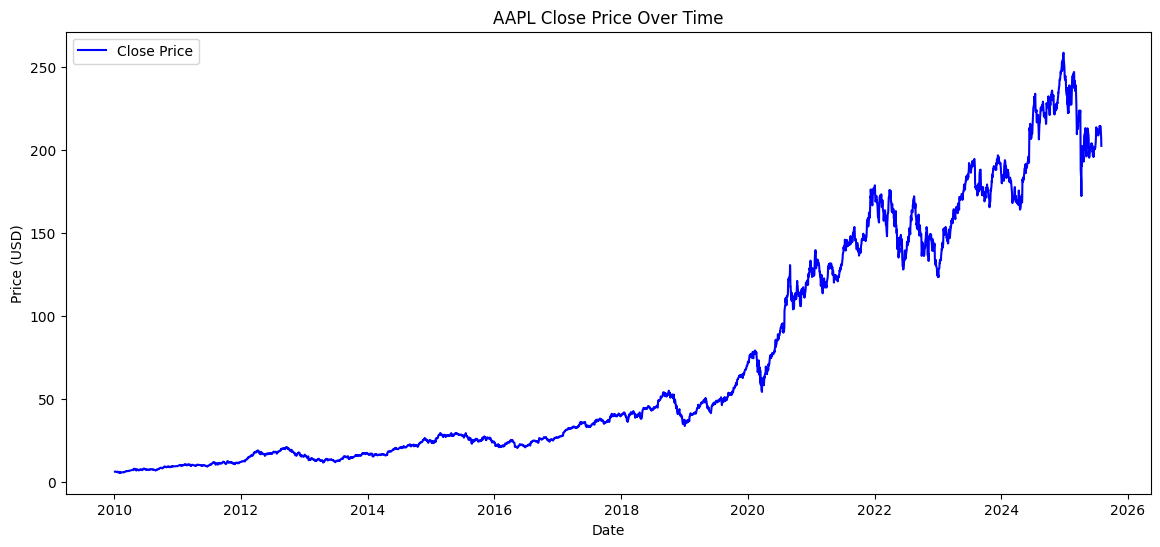

In [6]:
# Plot Closing Price
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title("AAPL Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

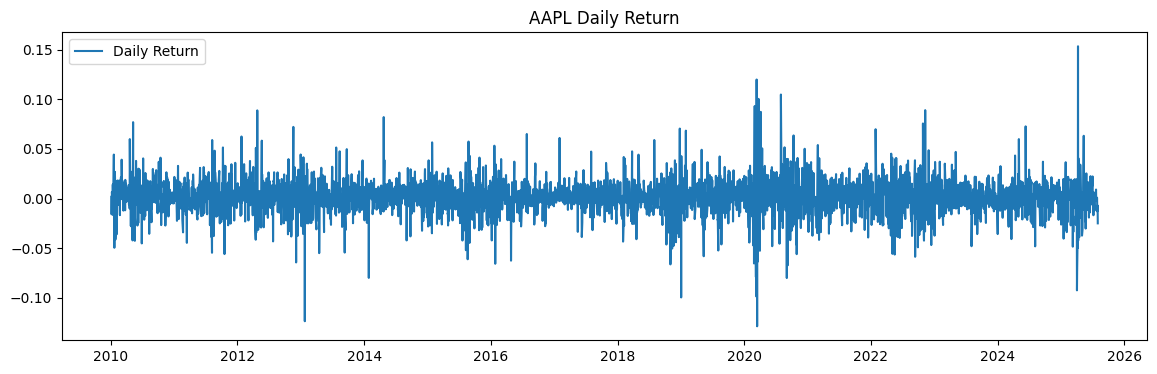

In [7]:
# Daily Returns
# Daily Return = (Today's Close - Yesterday's Close) / Yesterday's Close
df['Daily Return'] = df['Close'].pct_change()
plt.figure(figsize=(14, 4))
plt.plot(df['Daily Return'], label='Daily Return')
plt.title("AAPL Daily Return")
plt.legend()
plt.show()

Daily returns are the percentage change in closing price from one day to the next.
## Though there are sharp spikes and dips as expected for a stock, there is a sharp dip and then a spike indicating high volatility in early 2020 due to Covid-19.


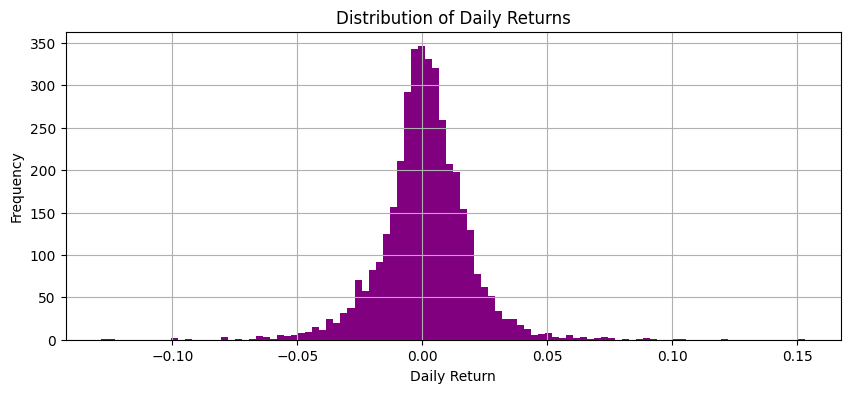

In [8]:
# Histogram of Returns
plt.figure(figsize=(10, 4))
df['Daily Return'].hist(bins=100, color='purple')
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

### Histogram is normally distributed around 0 indicating most returns are close to 0, with fewer extreme gains/losses.

In [9]:
# Linear Trend Line
from sklearn.linear_model import LinearRegression
X = df_reset['Date_ordinal'].values.reshape(-1, 1)
y = df_reset['Close'].values.reshape(-1, 1)
lin_reg = LinearRegression()
lin_reg.fit(X, y)
df_reset['Trend_Line'] = lin_reg.predict(X)

In [10]:
# Moving Average Trend (30-day)
df['MA30'] = df['Close'].rolling(window=30).mean()

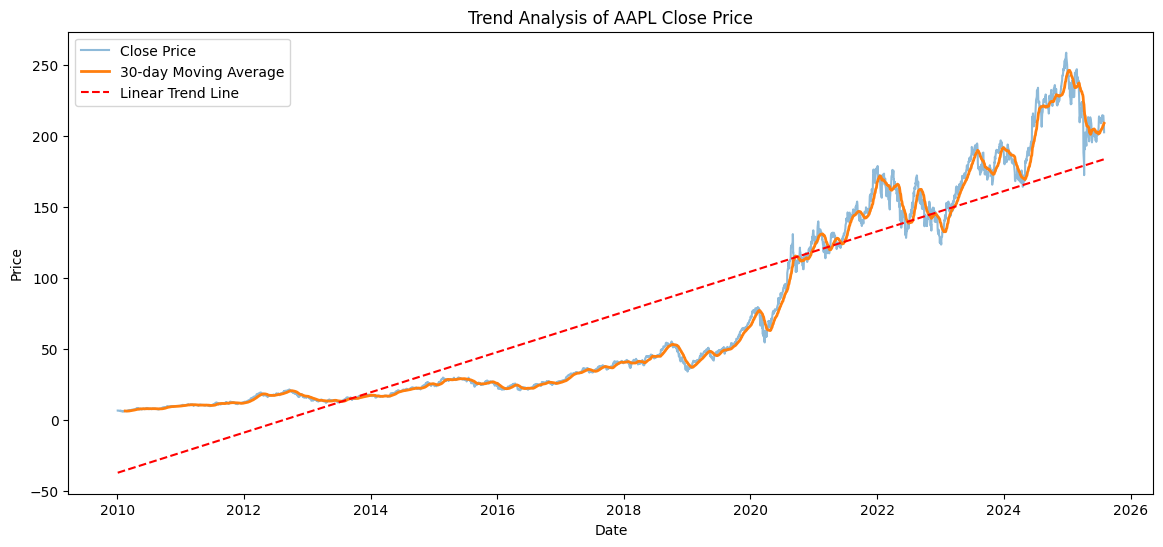

In [11]:
# Plot Trend
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
plt.plot(df.index, df['MA30'], label='30-day Moving Average', linewidth=2)
plt.plot(df_reset['Date'], df_reset['Trend_Line'], label='Linear Trend Line', color='red', linestyle='--')
plt.title('Trend Analysis of AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

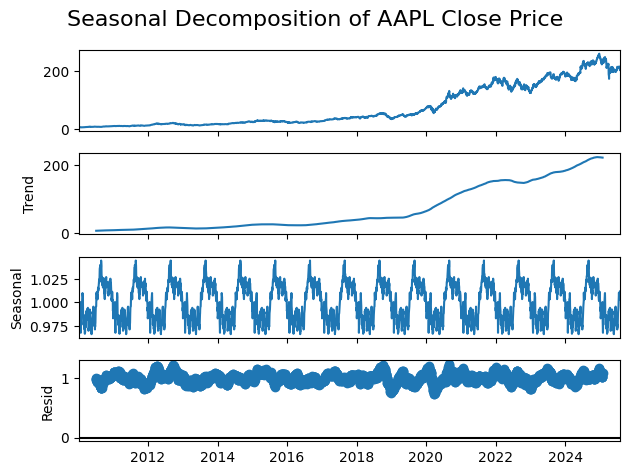

In [12]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=252)  # roughly 1 trading year
result.plot()
plt.suptitle('Seasonal Decomposition of AAPL Close Price', fontsize=16)
plt.tight_layout()
plt.show()

In finance, volatility refers to the degree of variation of a trading price series over time.
Statistically, it's measured by the standard deviation of returns — higher values mean larger price fluctuations (more risk).

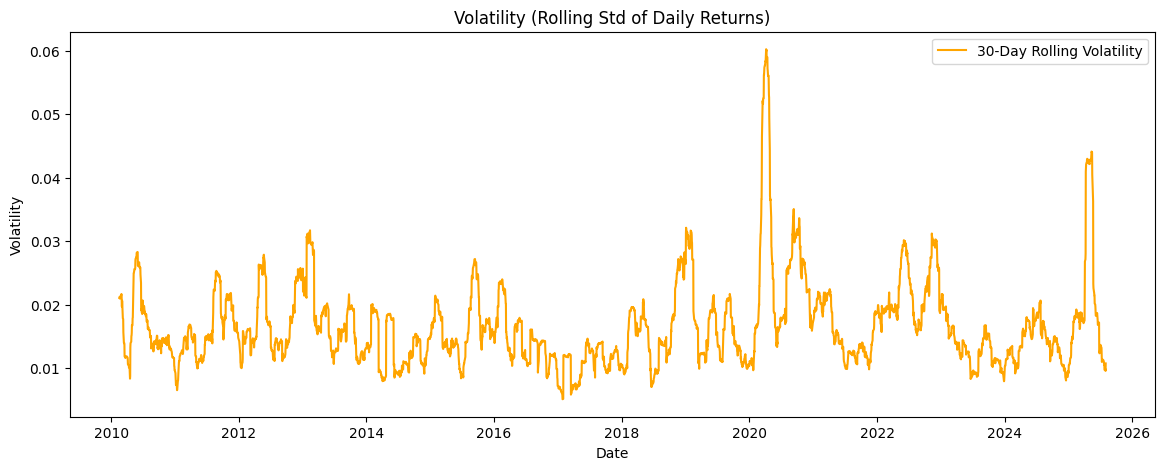

In [13]:
# Rolling Std Dev (Volatility)
df['Volatility (30d)'] = df['Daily Return'].rolling(window=30).std()
# Plot Volatility
plt.figure(figsize=(14,5))
plt.plot(df.index, df['Volatility (30d)'], label='30-Day Rolling Volatility', color='orange')
plt.title('Volatility (Rolling Std of Daily Returns)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

There is a high volatility spike during COVID in 2020, indicating high price fluctuations which implies more risk.

In [14]:
# Train-test split
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

In [58]:
len(df_test)

784

In [15]:
# Check stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is Non-Stationary")
    else:
        print("Series is Stationary")

In [16]:
adf_test(df_train['Close'])

ADF Statistic: 0.48802056009262273
p-value: 0.9845044067375829
Series is Non-Stationary


In [17]:
train_diff = df_train['Close'].diff().dropna()

In [18]:
# Check stationarity again after differencing
print("\nADF Test after 1st differencing:")
adf_test(train_diff)


ADF Test after 1st differencing:
ADF Statistic: -10.655381680664515
p-value: 4.548526644984688e-19
Series is Stationary


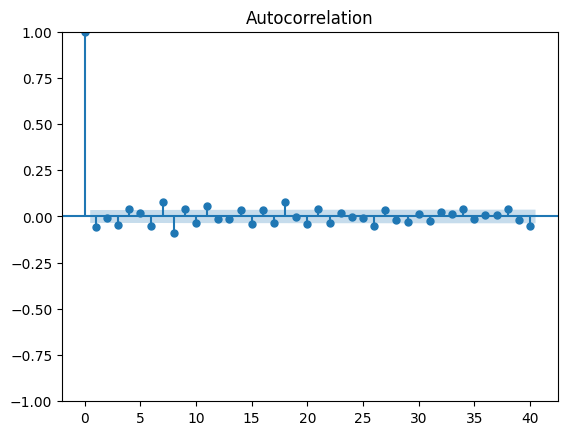

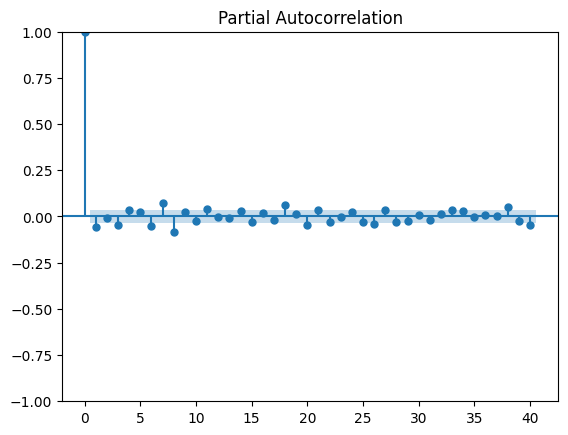

In [19]:
# Plot ACF and PACF
plot_acf(train_diff, lags=40)
plot_pacf(train_diff, lags=40)
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

In [21]:
# Feature Engineering
df['Return'] = df['Close'].pct_change()
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['STD_5'] = df['Close'].rolling(window=5).std()
df['Volume_Change'] = df['Volume'].pct_change()
df['High_Low_Spread'] = df['High'] - df['Low']

In [22]:
# Drop rows with NaNs from rolling and shift
df.dropna(inplace=True)

In [23]:
# Define target (predict next day’s close)
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)  # Drop last row with NaN target

In [24]:
# 4. Feature set
features = ['Lag_1', 'Lag_2', 'Lag_3', 'MA_5', 'MA_10', 'STD_5', 'Return', 'Volume_Change', 'High_Low_Spread']
X = df[features]
y = df['Target']

In [25]:
# Use the first 80% for training, last 20% for testing (chronologically) for ML models
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [26]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("MAE (Linear):", mean_absolute_error(y_test, lr_pred))

Linear Regression RMSE: 3.7968097215441285
MAE (Linear): 2.712032553637254


In [28]:
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test_scaled)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("MAE (RF):", mean_absolute_error(y_test, rf_pred))

Random Forest RMSE: 30.529209644238783
MAE (RF): 20.845470820527453


In [29]:
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test_scaled)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("MAE (XGBoost):", mean_absolute_error(y_test, xgb_pred))

XGBoost RMSE: 30.656659054990406
MAE (XGBoost): 20.918284899164902


## So, linear Regression outperformed RF, and XGBoost but it was only done for one time-step ahead. Let's do multistep ahead forecasting.

In [30]:
#from pmdarima import auto_arima
#stepwise_model = auto_arima(df_train['Close'],
#                            start_p=0, start_q=0,
#                            max_p=5, max_q=5,
#                            d=None,           # Let it determine d with test
#                            seasonal=False,   # Financial markets are affected by news, sentiment, and external shocks, not repeating calendar-based cycles (like sales at Diwali or summer peaks).
#                            trace=True,
#                            error_action='ignore',
#                            suppress_warnings=True,
#                            stepwise=True)

# print(f"Optimal ARIMA order: {stepwise_model.order}")

In [31]:
# ARIMA Model
model_arima = ARIMA(df_train['Close'], order=(5,2,0))
model_fit_arima = model_arima.fit()
forecast_arima = model_fit_arima.forecast(steps=len(df_test['Close']))
rmse_arima = np.sqrt(mean_squared_error(df_test['Close'], forecast_arima))
mae_arima = mean_absolute_error(df_test['Close'], forecast_arima)
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE: {mae_arima:.2f}")

ARIMA RMSE: 713.02
ARIMA MAE: 619.64


In [32]:
# Exponential Smoothing
model_ets = ExponentialSmoothing(df_train['Close'], trend='add', seasonal='add', seasonal_periods=252)
model_fit_ets = model_ets.fit()
forecast_ets = model_fit_ets.forecast(len(df_test))
rmse_ets = np.sqrt(mean_squared_error(df_test['Close'], forecast_ets))
mae_ets = mean_absolute_error(df_test['Close'], forecast_ets)
print(f"ETS RMSE: {rmse_ets:.2f}")
print(f"ETS MAE: {mae_ets:.2f}")

ETS RMSE: 48.58
ETS MAE: 41.40


In [33]:
# Step 7: Prophet Model
from prophet import Prophet

# Fix: explicitly select only Date and Close and reset index
prophet_df = df.reset_index()[['Date', 'Close']]
# Flatten the multi-level columns
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])  # ensure ds is datetime

split_index = int(len(prophet_df) * 0.8) # Use prophet_df for splitting
prophet_train = prophet_df.iloc[:split_index].copy()
prophet_test = prophet_df.iloc[split_index:].copy()


In [34]:
prophet_df.columns

Index(['ds', 'y'], dtype='object')

In [35]:
model_prophet = Prophet()

In [36]:
model_prophet.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1f4pwk7b/30j4kibm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1f4pwk7b/fy_ebppc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1098', 'data', 'file=/tmp/tmp1f4pwk7b/30j4kibm.json', 'init=/tmp/tmp1f4pwk7b/fy_ebppc.json', 'output', 'file=/tmp/tmp1f4pwk7b/prophet_modelbd36b27c/prophet_model-20250803044204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:42:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:42:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
future = model_prophet.make_future_dataframe(periods=len(df_test))
forecast_prophet = model_prophet.predict(future)

In [38]:
future.tail()

,ds
3889,2024-08-11
3890,2024-08-12
3891,2024-08-13
3892,2024-08-14
3893,2024-08-15


In [39]:
df.shape

(3888, 18)

In [40]:
future.shape

(3894, 1)

In [41]:
forecast_prophet.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3889,2024-08-11,266.695054,244.779922,289.628899,245.473270,286.711318,1.234497,1.234497,1.234497,-0.578449,-0.578449,-0.578449,1.812946,1.812946,1.812946,0.0,0.0,0.0,267.929551
3890,2024-08-12,266.811888,246.440605,290.715464,245.557362,286.875498,2.212795,2.212795,2.212795,0.264749,0.264749,0.264749,1.948047,1.948047,1.948047,0.0,0.0,0.0,269.024683
3891,2024-08-13,266.928722,245.856707,290.202841,245.641455,287.035157,2.371425,2.371425,2.371425,0.289578,0.289578,0.289578,2.081847,2.081847,2.081847,0.0,0.0,0.0,269.300147
3892,2024-08-14,267.045556,246.963349,290.072035,245.725547,287.192109,2.503198,2.503198,2.503198,0.290253,0.290253,0.290253,2.212946,2.212946,2.212946,0.0,0.0,0.0,269.548755
3893,2024-08-15,267.162391,246.692856,290.162310,245.809639,287.327494,2.531653,2.531653,2.531653,0.191661,0.191661,0.191661,2.339992,2.339992,2.339992,0.0,0.0,0.0,269.694043


In [42]:
# Extract forecasted values
# Merge forecast with test data on date
prophet_forecast = forecast_prophet[['ds', 'yhat']].set_index('ds')
prophet_forecast = prophet_forecast.loc[prophet_forecast.index.isin(df_test.index)]
aligned_test = df_test.loc[df_test.index.isin(prophet_forecast.index)]

rmse_prophet = np.sqrt(mean_squared_error(aligned_test['Close'], prophet_forecast['yhat']))
mae_prophet = mean_absolute_error(aligned_test['Close'], prophet_forecast['yhat'])

print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE: {mae_prophet:.2f}")

Prophet RMSE: 52.81
Prophet MAE: 50.59


In [43]:
from sklearn.preprocessing import MinMaxScaler

# Normalize
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(df_train[['Close']])
scaled_test = scaler.transform(df_test[['Close']])

In [44]:
scaled_train.shape

(3135, 1)

In [45]:
scaled_test.shape

(784, 1)

In [46]:
# Parameters
sequence_length = 300 # Number of past days used to predict next day

In [47]:
# Function to create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [48]:
# Create sequences for train and test
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

In [49]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2835, 300, 1)
(2835, 1)
(484, 300, 1)
(484, 1)


In [50]:
# Reshape for LSTM input: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 300, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 300, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0308 - val_loss: 0.0336
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 5.5586e-04 - val_loss: 0.0161
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.7658e-04 - val_loss: 0.0160
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 4.8509e-04 - val_loss: 0.0107
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.1935e-04 - val_loss: 0.0127
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.9933e-04 - val_loss: 0.0055
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.4470e-04 - val_loss: 0.0123
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.0402e-04 - val_loss: 0.0114
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 3.3817e-04 - val_loss: 0.0171
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.3818e-04 - val_loss: 0.0095
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.4040e-04 - val_loss: 0.0061
Epoch 12/100

In [54]:
# Lets do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [55]:
# Inverse scale predictions and y_test
predicted_prices = scaler.inverse_transform(test_predict)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)) # reshape into 2d array:(n_samples, 1)

In [56]:
# Evaluation
rmse_lstm = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae_lstm = mean_absolute_error(actual_prices, predicted_prices)
print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE : {mae_lstm:.2f}")

LSTM RMSE: 4.76
LSTM MAE : 3.69


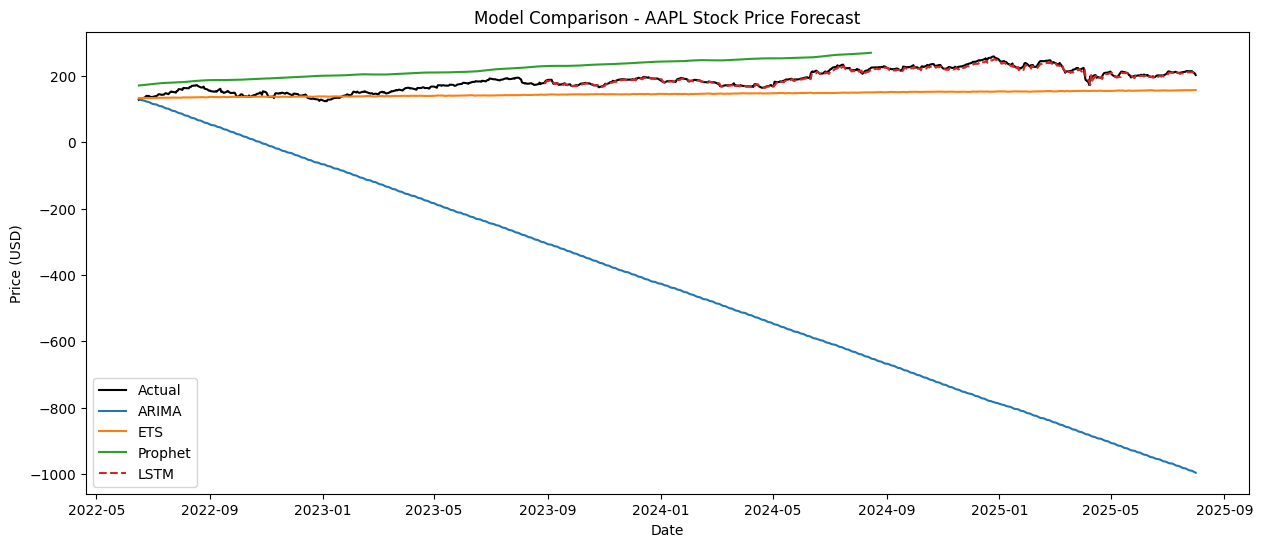

In [57]:
plt.figure(figsize=(15, 6))
plt.plot(df_test.index, df_test['Close'], label='Actual', color='black')
plt.plot(df_test.index, forecast_arima, label='ARIMA')
plt.plot(df_test.index, forecast_ets, label='ETS')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet')

# For LSTM, shift predictions so they align with test dates
lstm_start = df_test.index[sequence_length]  # offset because LSTM loses first `sequence_length` predictions
lstm_index = df_test.index[sequence_length:]
plt.plot(lstm_index, predicted_prices.flatten(), label='LSTM', linestyle='--')

plt.title("Model Comparison - AAPL Stock Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

##In our comparison, LSTM was evaluated using rolling 1-step predictions with access to actual test inputs, while ARIMA, ETS, and Prophet used multi-step forecasting based solely on train data. This gives LSTM an inherent advantage in accuracy, and explains why its RMSE and MAE are lower. For a fairer evaluation, all models can be made to operate under the same recursive prediction strategy.

In [62]:
# Number of days to forecast
n_days = 90
input_seq_len = 300

In [63]:
# Take the last 300 scaled values from test set
last_sequence = scaled_test[-input_seq_len:].reshape(1, input_seq_len, 1)

future_predictions = []

for _ in range(n_days):
    # Predict the next day
    next_pred = model.predict(last_sequence)[0][0]

    # Append the prediction
    future_predictions.append(next_pred)

    # Update the sequence: drop first, append the new prediction
    next_input = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)
    last_sequence = next_input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [64]:
# Inverse transform to get original scale
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [65]:
# Create future date index
last_date = df_test.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days, freq='B')

# Create DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_prices.flatten()})
future_df.set_index('Date', inplace=True)

# Display forecast
print(future_df)

            Predicted_Close
Date                       
2025-08-04       199.786575
2025-08-05       198.439636
2025-08-06       197.094940
2025-08-07       195.470062
2025-08-08       193.874191
...                     ...
2025-12-01       157.375183
2025-12-02       157.259842
2025-12-03       157.146835
2025-12-04       157.036072
2025-12-05       156.927536

[90 rows x 1 columns]


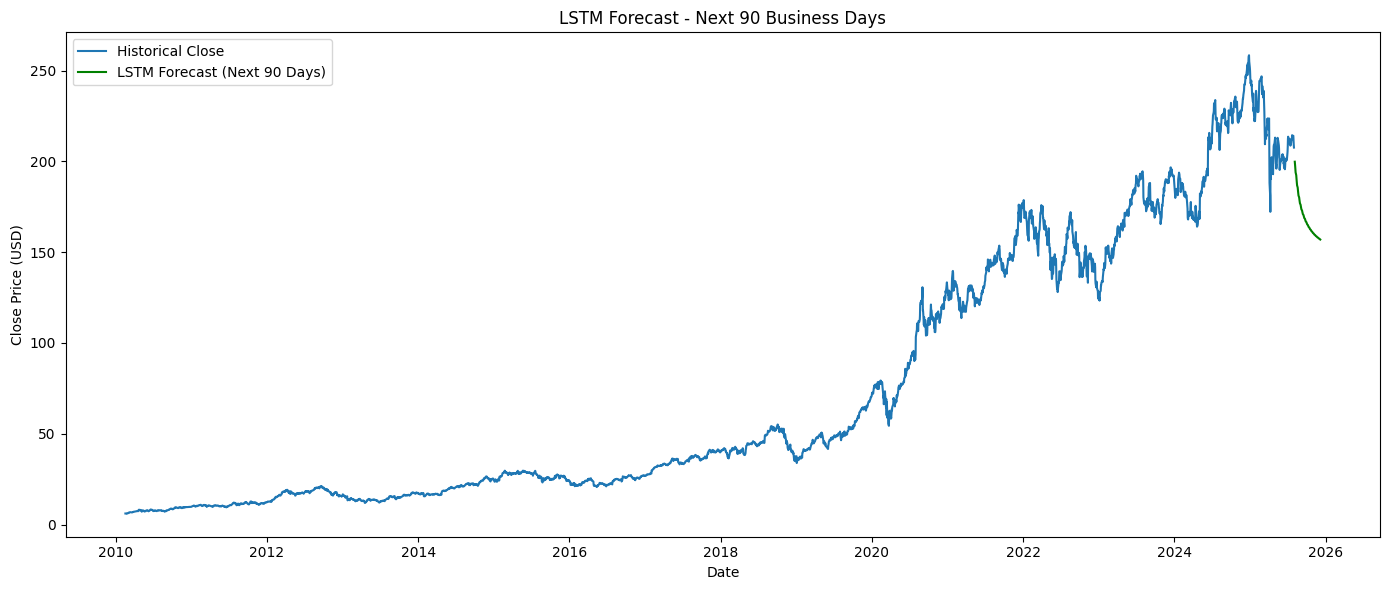

In [66]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Historical Close')
plt.plot(future_df.index, future_df['Predicted_Close'], label='LSTM Forecast (Next 90 Days)', color='green')
plt.title("LSTM Forecast - Next 90 Business Days")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

## CONCLUSION: While Linear Regression is fast and interpretable for near-term predictions, Stacked LSTM is generally more robust and accurate for longer-term, multi-step stock price forecasting — provided we have enough data and tune it well.

In [69]:
print("TensorFlow:", tf.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("YFinance:", yf.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Statsmodels:", sm.__version__)

TensorFlow: 2.18.0
Scikit-learn: 1.6.1
Pandas: 2.2.2
Numpy: 2.0.2
YFinance: 0.2.65
Matplotlib: 3.10.0
Statsmodels: 0.14.5


In [70]:
model.save("lstm_model.h5")

In [71]:
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("last_sequence.pkl", "wb") as f:
    pickle.dump(last_sequence, f)